In [2]:
import numpy as np
import os
import glob
import pandas as pd
from astropy.io import fits
from datetime import timedelta, date
from datetime import datetime
from alive_progress import alive_bar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#--------------------------------------------------------------------
# Functions
#--------------------------------------------------------------------
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days +1)):
        yield start_date + timedelta(n)

#--------------------------------------------------------------------
# Read CCFs
#--------------------------------------------------------------------
quality_df  = pd.read_csv('./lib/combined_rvs_1.csv')
filenames   = [quality_df['Filename'][i][-27:] for i in range(len(quality_df))]
path_prefix = '/gpfs/group/ebf11/default/pipeline/data/neid_solar/v1.1/outputs/jvz5625/'

In [3]:
len(quality_df)

31795

In [43]:
start_date  = date(2020, 1, 1)
# end_date  = date(2020, 1, 1)
end_date    = date(2020, 12, 31)

plot        = False
o_start     = 55    # 56 in Julia (physical 118)
o_end       = 108   # 108 in julia (physical 65)
# o_exclude   = np.array([61, 66, 81, 90]) -> version 1 (data_v1)
# o_exclude   = 173 - np.array([66, 67, 68, 74, 76, 83, 118]) # -> version 2 (data); index starting from 0
# o_exclude   = 173 - np.array([66, 67, 68, 69, 73, 74, 75, 76, 83, 118]) # -> version 3 (data_v3); index starting from 0
o_exclude   = 173 - np.array([66, 67, 68, 69, 73, 74, 75, 76, 78, 83, 107,108,112,113,117, 118]) # -> version 4 (data_v4);
o_used      = np.array([x for x in np.arange(o_start, o_end) if (x in o_exclude) == False])

v_grid      = -100 + np.arange(1604)*0.25
idx_v       = (v_grid>87) & (v_grid<111)

CCF, σCCF                       = [], []
bjd, rv, σrv                    = np.array([]), np.array([]), np.array([])
CCF_daily, σCCF_daily           = [], []
bjd_daily, rv_daily, σrv_daily  = np.array([]), np.array([]), np.array([])

CCF_used_orders = []

In [ ]:
start_time  = datetime.now()
for single_date in daterange(start_date, end_date):

    print(single_date.strftime("%Y-%m-%d"))

    path        = path_prefix + single_date.strftime('extracted_ccf/%m/%d/')
    file_ccf    = sorted(glob.glob(path + '/*.ccf')) 
    N_file      = len(file_ccf)

    # path_save   = path_prefix + single_date.strftime('ccf_by_obs_56_108/%m/%d/')
    # if not os.path.exists(path_save):
    #     os.makedirs(path_save)

    if N_file != 0:

        with alive_bar(N_file) as bar:

            for n in range(N_file):
                ccf_per_order   = np.loadtxt(file_ccf[n])

                # for order in o_used:
                #     if ccf_per_order[order, :].all() == 0:
                #         continue
                    # else:
                    #     reg                     = LinearRegression().fit(v_grid[~idx_v].reshape(-1,1), ccf_per_order[order, ~idx_v])
                    #     fitted_continuum        = reg.predict(v_grid.reshape(-1,1))
                    #     ccf_per_order[order, :] = ccf_per_order[order, :] / fitted_continuum * np.median(fitted_continuum)

                ccf_per_obs   = np.sum(ccf_per_order[o_used, :], axis=0)
                CCF_used_orders.append(ccf_per_order[o_used, :])

                # np.savetxt(path_save + file_ccf[n][-27:-4] + '.ccf', ccf_per_obs)

                if not np.any(CCF):
                    CCF = ccf_per_obs #(1604,)
                else:
                    CCF = np.vstack((CCF, ccf_per_obs)) # e.g.(53, 1604)

                df      = quality_df[quality_df['Filename'].str.contains(file_ccf[n][-26:-4])]
                bjd     = np.append(bjd, df['jd_drp'])
                rv      = np.append(rv, df['rv_drp']*1000)
                σrv     = np.append(σrv, df['σrv_drp']*1000)

                bar()

                if (n==0) & (plot==True): # only plot once
                
                    ccf_per_order_reject = np.vstack((ccf_per_order[0:o_start, :], ccf_per_order[o_end:, :]))
                    continuum   = np.mean(ccf_per_order_reject, axis=1)
                    idx         = (continuum!=0)
                    plt.plot(v_grid, ccf_per_order_reject[idx,:].T/continuum[idx], 'r', alpha=0.1)

                    continuum   = np.mean(ccf_per_order[o_used, :], axis=1)
                    idx         = (continuum!=0)
                    plt.plot(v_grid, ccf_per_order[o_used, :][idx,:].T/continuum[idx], 'b', alpha=0.1)
                    plt.show()

                    for i in range(ccf_per_order.shape[0]):
                        plt.plot(v_grid, ccf_per_order[i,:])
                        plt.title('Julia index' + str(i+1) + ' / order ' + str(174-i-1))
                        plt.show()

CCF_used_orders = np.stack(CCF_used_orders)                        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

2020-01-01
|████████████████████████████████████████| 204/204 [100%] in 21.8s (9.35/s) 
2020-01-02
|████████████████████████████████████████| 139/139 [100%] in 20.7s (6.71/s) 
2020-01-03
|████████████████████████████████████████| 208/208 [100%] in 31.5s (6.61/s) 
2020-01-04
2020-01-05
|████████████████████████████████████████| 137/137 [100%] in 20.5s (6.69/s) 
2020-01-06
|████████████████████████████████████████| 165/165 [100%] in 25.4s (6.50/s) 
2020-01-07
|████████████████████████████████████████| 154/154 [100%] in 23.3s (6.61/s) 
2020-01-08
|████████████████████████████████████████| 93/93 [100%] in 14.1s (6.62/s) 
2020-01-09
|████████████████████████████████████████| 227/227 [100%] in 35.3s (6.42/s) 
2020-01-10
|████████████████████████████████████████| 222/222 [100%] in 34.5s (6.44/s) 
2020-01-11
|████████████████████████████████████████| 194/194 [100%] in 31.6s (6.15/s) 
2020-01-12
|████████████████████████████████████████| 205/205 [100%] in 33.5s (6.11/s) 
2020-01-13
2020-01-14
2

In [1]:
CCF_used_orders.shape

NameError: name 'CCF_used_orders' is not defined

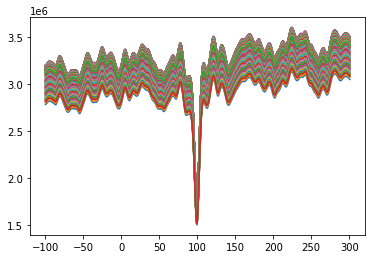

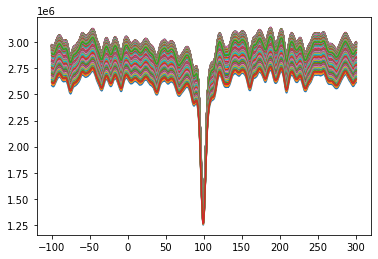

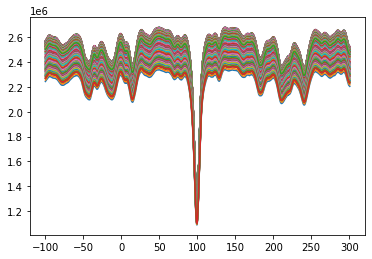

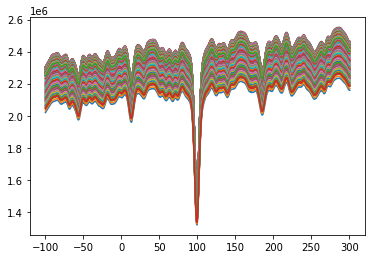

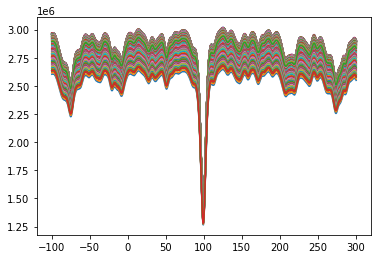

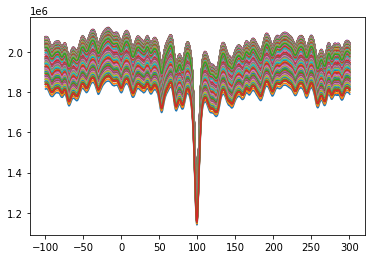

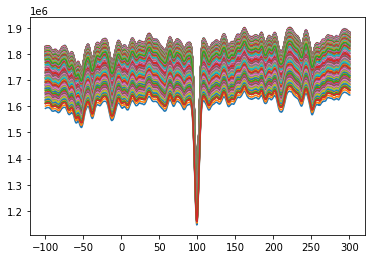

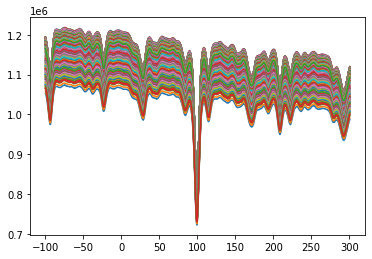

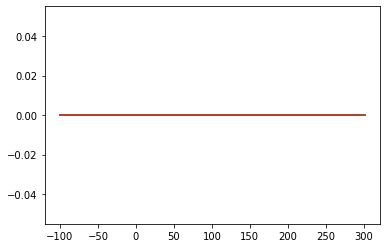

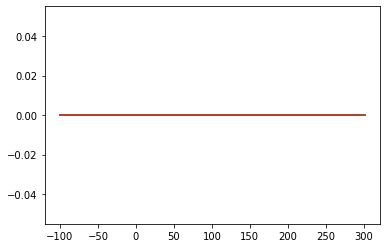

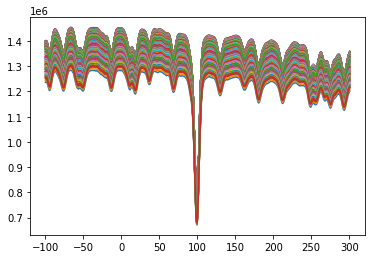

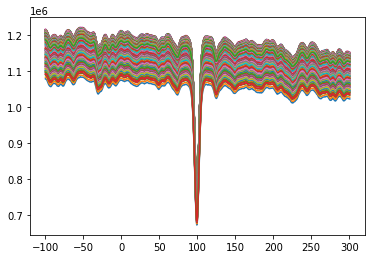

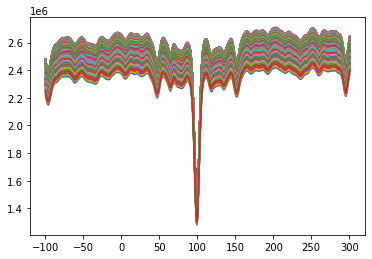

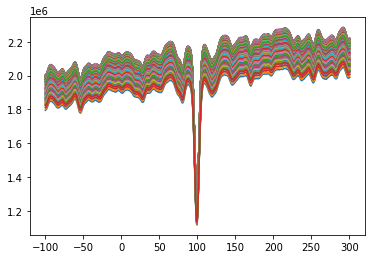

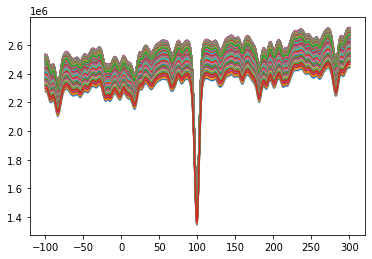

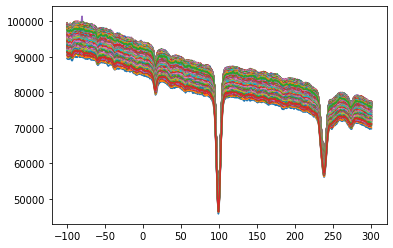

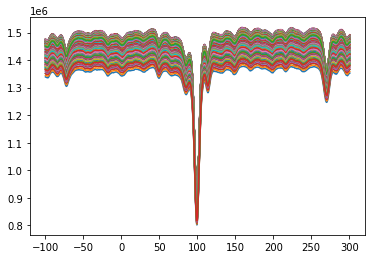

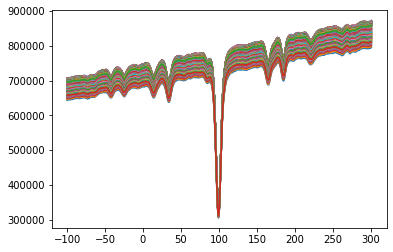

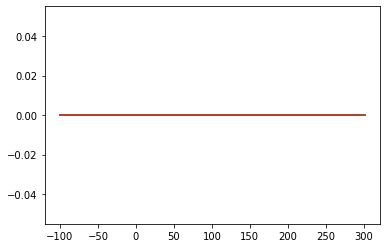

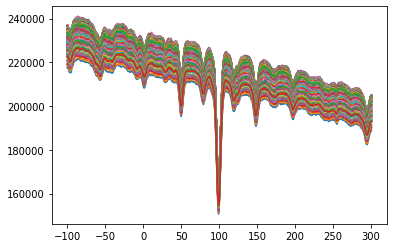

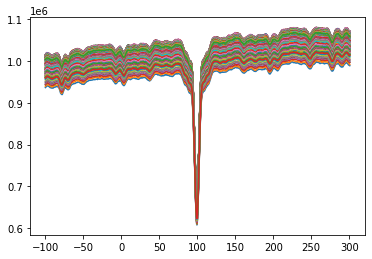

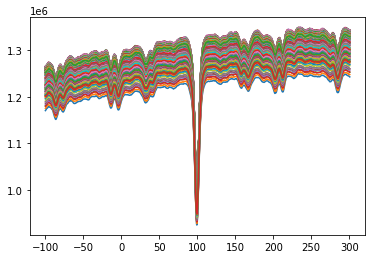

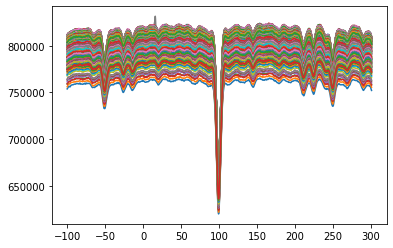

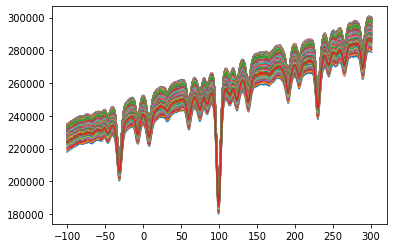

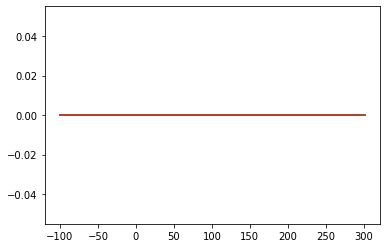

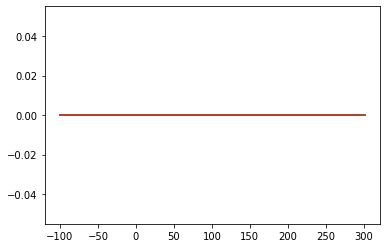

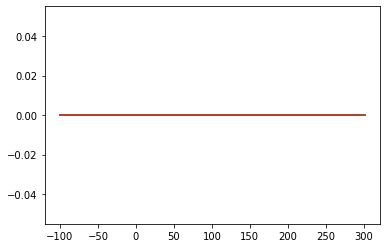

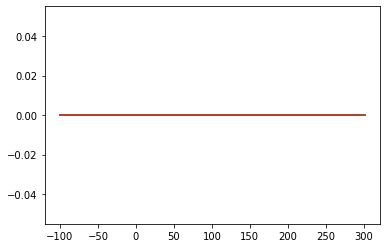

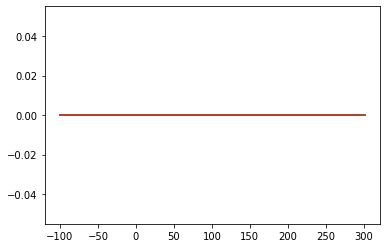

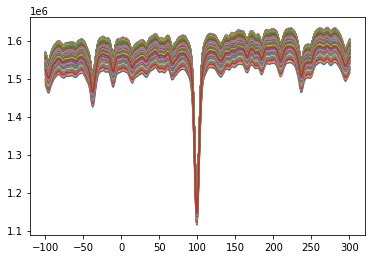

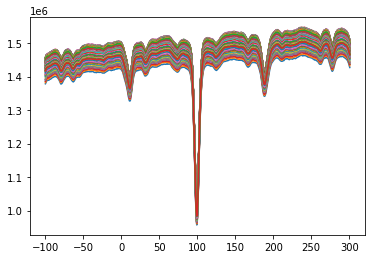

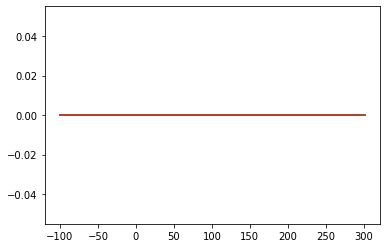

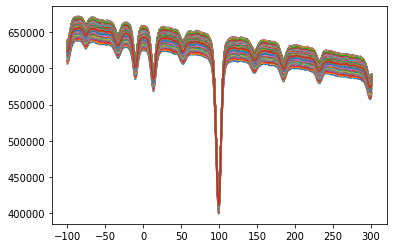

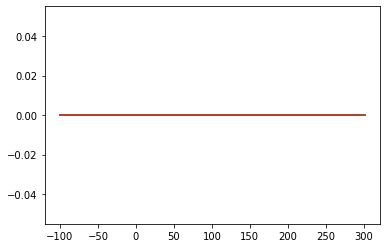

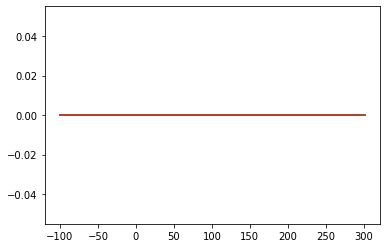

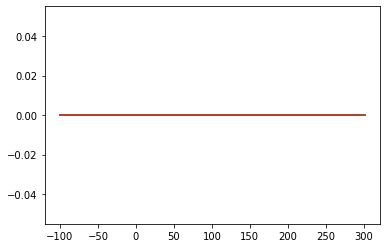

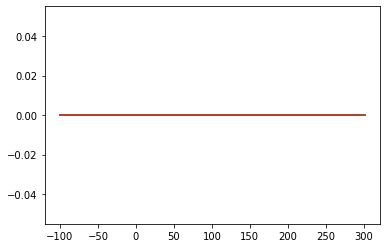

In [42]:
for i in range(37):
    plt.plot(v_grid, CCF_used_orders[:,i,:].T)
    plt.show()